In [2]:

import sys
sys.path.append('../')


from glob import glob
from src.tacogfn.utils.molecules import sdf_to_single_smiles

from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import BRICS

import re
import pandas as pd
from rdkit.Chem import rdmolops
import datamol as dm

In [3]:
def fix_mol(mol):
    mol = dm.fix_mol(mol)
    mol = dm.sanitize_mol(mol, sanifix=True, charge_neutral=True)
    mol = dm.standardize_mol(
        mol,
        disconnect_metals=False,
        normalize=True,
        reionize=True,
        uncharge=False,
        stereo=True,
    )
    return mol

In [4]:
# Replace the dummy atom index
pattern = r'\[\d+\*\]'

In [5]:
def brics(smiles):
    dm.disable_rdkit_log()
    
    mol = Chem.MolFromSmiles(smiles)
    
    mol = dm.standardize_mol(
        mol,
        disconnect_metals=False,
        normalize=True,
        reionize=True,
        uncharge=True,
        stereo=True,
    )
    
    fragmented_mol = rdmolops.FragmentOnBRICSBonds(mol)
    fragments = Chem.GetMolFrags(fragmented_mol, asMols=True, sanitizeFrags=True)
    
    # Kekulize the fragments
    for fragment in fragments:
        Chem.Kekulize(fragment, clearAromaticFlags=True) 
    
    # Break the ring connecting bonds
    new_fragments = []
    for frag in fragments:
        new_fragments.extend(break_ring_connecting_bonds(frag))
    
    # Remove fragment where dummy atom is connected via a NON-single bond
    new_fragments = [frag for frag in new_fragments if not has_attachment_point_via_non_single_bond(frag)]
    
    fragment_smiles = [Chem.MolToSmiles(fragment, isomericSmiles=False) for fragment in new_fragments]
    fragment_smiles = [re.sub(pattern, '[*]', smiles) for smiles in fragment_smiles]
    
    return set(fragment_smiles)

In [6]:
def has_attachment_point_via_non_single_bond(frag):
    for bond in frag.GetBonds():
        atom1, atom2 = bond.GetBeginAtom(), bond.GetEndAtom()
        if atom1.GetAtomicNum() == 0 or atom2.GetAtomicNum() == 0:
            if bond.GetBondTypeAsDouble() != 1.0:
                return True
    return False

In [7]:
def break_ring_connecting_bonds(frag_mol):
    ring_info = frag_mol.GetRingInfo()
    ring_atoms = set(sum(ring_info.AtomRings(), ()))
    ring_bonds = set(sum(ring_info.BondRings(), ()))

    ring_connecting_bonds = []

    for bond in frag_mol.GetBonds():
        if bond.GetIdx() not in ring_bonds:
            atom1, atom2 = bond.GetBeginAtom(), bond.GetEndAtom()
            if atom1.GetAtomicNum() == 0 or atom2.GetAtomicNum() == 0:
                # Skip this bond if either atom is a dummy atom
                continue
            
            # Skip this bond if it is not a single bond
            if bond.GetBondTypeAsDouble() != 1.0:
                continue
            
            atom1_idx, atom2_idx = atom1.GetIdx(), atom2.GetIdx()
            if atom1_idx in ring_atoms or atom2_idx in ring_atoms:
                ring_connecting_bonds.append(bond.GetIdx())
    
    if len(ring_connecting_bonds) == 0:
        return [frag_mol]
    
    fragmented_mol = Chem.FragmentOnBonds(
        frag_mol, ring_connecting_bonds)
    return Chem.GetMolFrags(fragmented_mol, asMols=True, sanitizeFrags=True)        

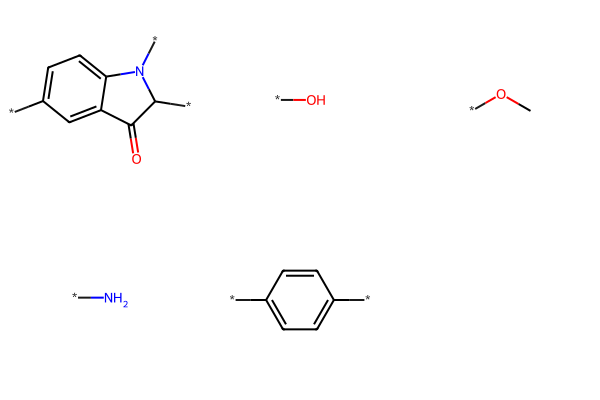

In [8]:
brics_frags = [Chem.MolFromSmiles(smi) for smi in brics(smiles_list[4])]
brics_frags = list(brics_frags)
MolsToGridImage(brics_frags)

In [9]:
from tqdm import tqdm
from collections import defaultdict

counter = defaultdict(int)

Create all fragments

In [10]:
for smi in tqdm(smiles_list):
    frags = brics(smi)
    for frag in frags:
        counter[frag] += 1

  0%|          | 26/13509 [00:00<00:52, 254.90it/s]

100%|██████████| 13509/13509 [00:46<00:00, 290.16it/s]


First, merge all fragments that are same (differ by connection point) - Second, compute all connection points 

In [11]:
def get_stems(frag_smi):
    mol = Chem.MolFromSmiles(frag_smi)
    Chem.Kekulize(mol, clearAromaticFlags=True)

    original_stem_indices = []    

    # Get the mapping from the original index to the index after removing dummy atoms
    j = 0
    no_dummy_idx_map = {}
    for i, atom in enumerate(mol.GetAtoms()):
        if atom.GetAtomicNum() != 0:
            no_dummy_idx_map[i] = j
            j += 1

    # Get the indices of the atoms that are connected to the dummy atoms
    for bond in mol.GetBonds():
        atom1, atom2 = bond.GetBeginAtom(), bond.GetEndAtom()
        if atom1.GetAtomicNum() == 0:
            original_stem_indices.append(no_dummy_idx_map[atom2.GetIdx()])
        if atom2.GetAtomicNum() == 0:
            original_stem_indices.append(no_dummy_idx_map[atom1.GetIdx()])
    
    no_wildcard_mol = Chem.DeleteSubstructs(mol, Chem.MolFromSmiles('[*]'))
    _ = Chem.MolFromSmiles(Chem.MolToSmiles(no_wildcard_mol))
    
    # Compute the new ordering when we cannocalize the smiles
    new_order = list(map(int, no_wildcard_mol.GetProp("_smilesAtomOutputOrder")[1:-2].split(",")))
    
    stems = []
    for idx in original_stem_indices:
        stems.append(new_order.index(idx))
    
    return stems

In [58]:
non_dup_counter = defaultdict(int)
mapping = defaultdict(set)

for frag_smi, count in tqdm(counter.items()):
    if count > 50:
        start_mol = Chem.MolFromSmiles(frag_smi)
        Chem.Kekulize(start_mol, clearAromaticFlags=True)        
        no_wildcard_mol = Chem.DeleteSubstructs(start_mol, Chem.MolFromSmiles('[*]'))
        try:
            no_wildcard_mol = fix_mol(no_wildcard_mol)
        except:
            no_wildcard_mol = no_wildcard_mol
        no_wildcard_smiles = Chem.MolToSmiles(no_wildcard_mol)
        non_dup_counter[no_wildcard_smiles] += count
        mapping[no_wildcard_smiles].add(frag_smi)

100%|██████████| 6814/6814 [00:00<00:00, 62443.03it/s]


In [59]:
key_to_stems = defaultdict(set)

for key, frag_set in tqdm(mapping.items()):
    for frag_smi in frag_set:
        for stem in get_stems(frag_smi):
            key_to_stems[key].add(stem)

100%|██████████| 63/63 [00:00<00:00, 1384.84it/s]


In [60]:
# key = 'C1=CSC=N1'
# print(key_to_stems[key])
# MolsToGridImage([Chem.MolFromSmiles(smi) for smi in mapping[key]], legends=[f'{str(counter[smi])} {[" ".join([str(i) for i in get_stems(smi)])]}' for smi in mapping[key]])

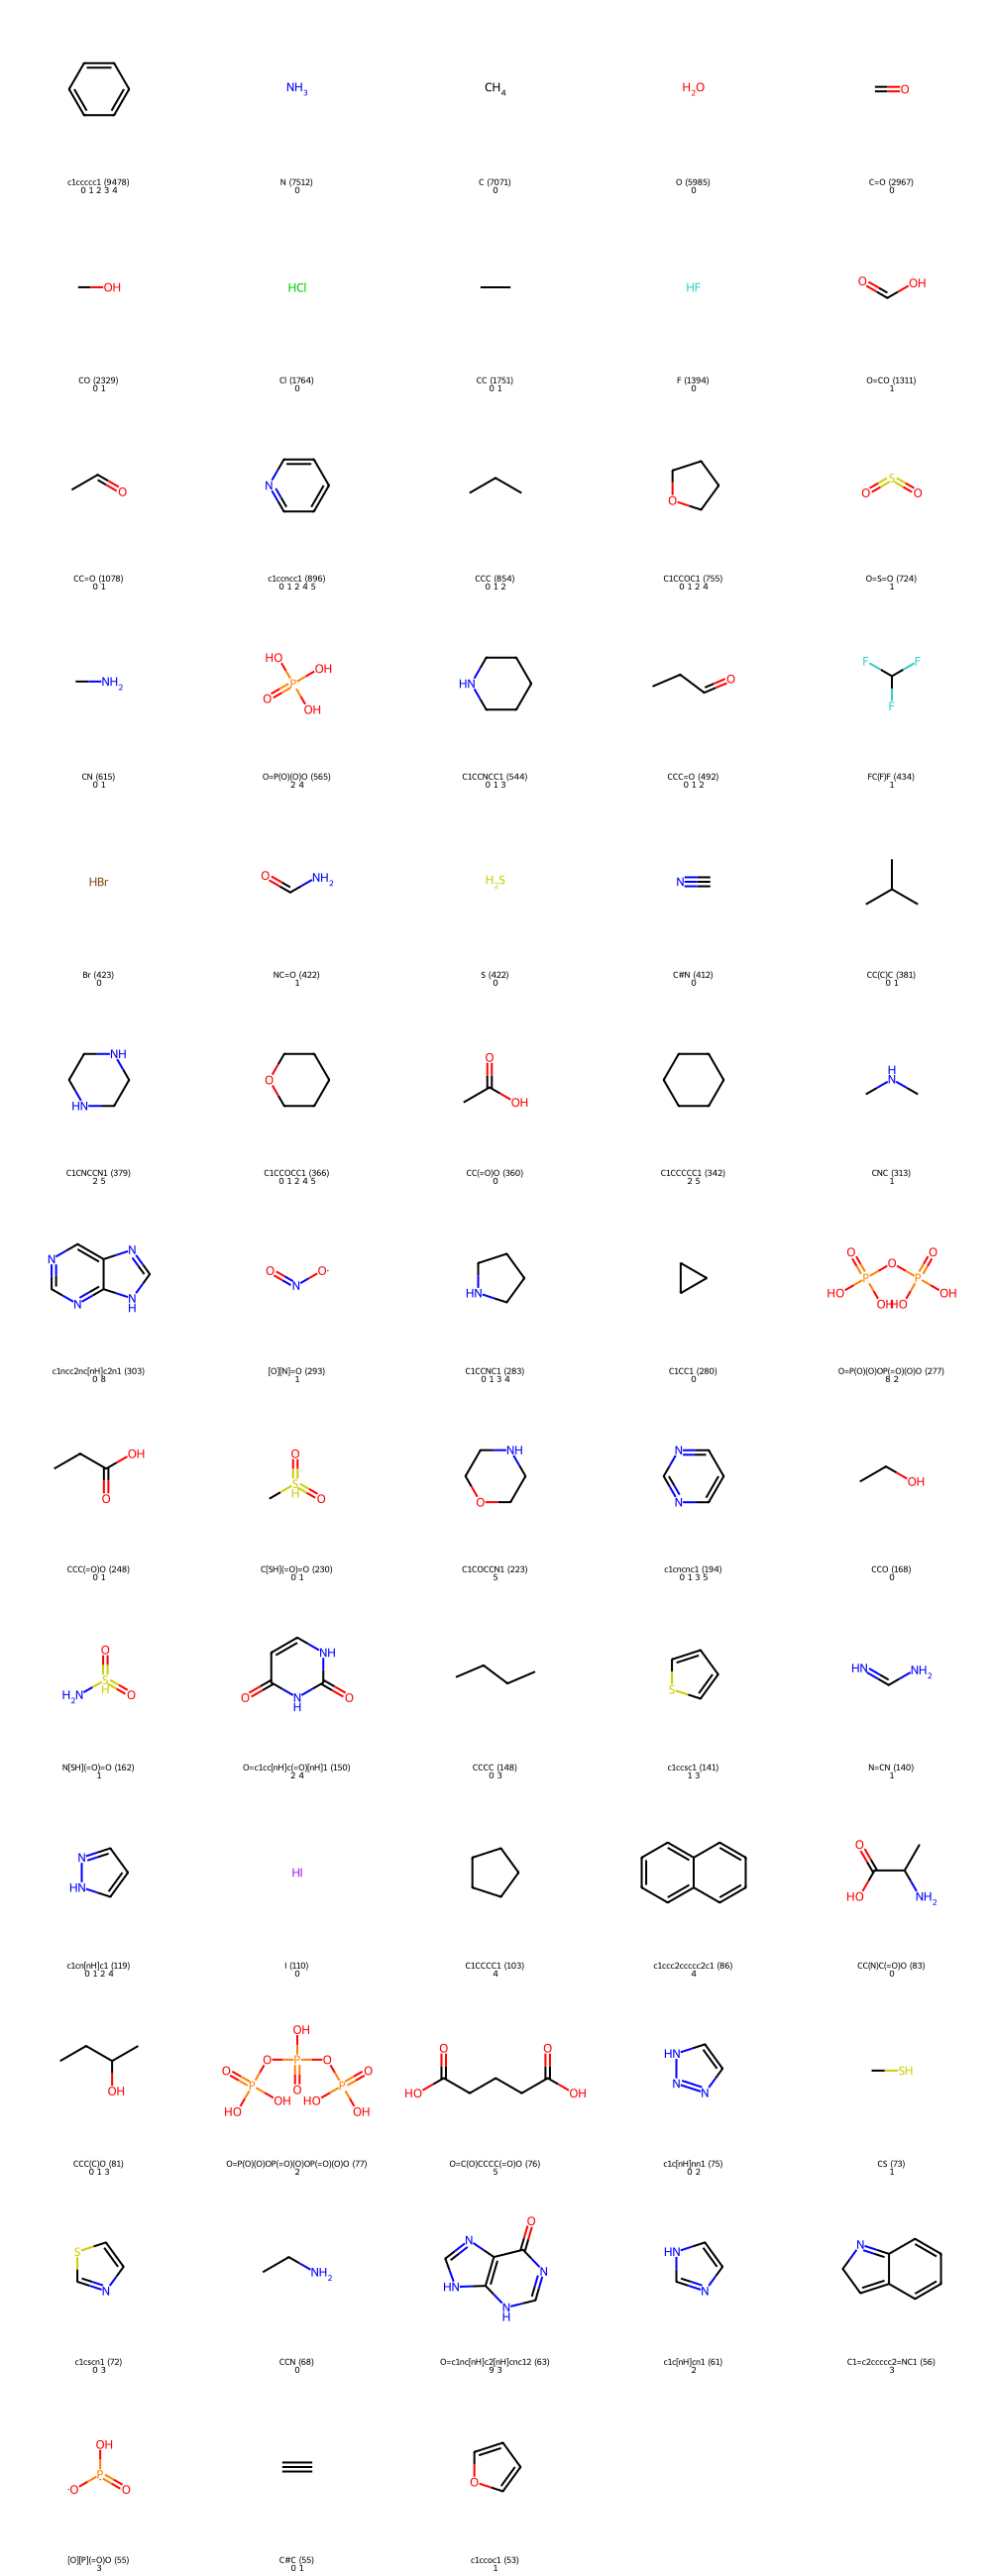

In [61]:
sorted_counter = dict(sorted(non_dup_counter.items(), key=lambda x: x[1], reverse=True))

size = 250

mols = [Chem.MolFromSmiles(smi) for smi in sorted_counter.keys()]

# For visualization reasons only
# for mol in mols:
#     if mol is not None:
#         for i, atom in enumerate(mol.GetAtoms()):
#             atom.SetAtomMapNum(i)

MolsToGridImage(mols[:size], molsPerRow=5, subImgSize=(200, 200), legends=[f'{smi} ({freq}) \n{" ".join([str(i) for i in key_to_stems[smi]])}' for smi, freq in sorted_counter.items()][:size], maxMols=size)

In [62]:
vocab = []
for smi, _ in sorted_counter.items():
    vocab.append(
        [smi, list(key_to_stems[smi])]
    )

In [63]:
import torch

torch.save(vocab, '../src/tacogfn/const/vocab_store/crossdock_50.pt')

In [5]:
import torch

torch.load('../src/tacogfn/const/vocab_store/crossdock_50.pt')

/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[['c1ccccc1', [0, 1, 2, 3, 4]],
 ['N', [0]],
 ['C', [0]],
 ['O', [0]],
 ['C=O', [0]],
 ['CO', [0, 1]],
 ['Cl', [0]],
 ['CC', [0, 1]],
 ['F', [0]],
 ['O=CO', [1]],
 ['CC=O', [0, 1]],
 ['c1ccncc1', [0, 1, 2, 4, 5]],
 ['CCC', [0, 1, 2]],
 ['C1CCOC1', [0, 1, 2, 4]],
 ['O=S=O', [1]],
 ['CN', [0, 1]],
 ['O=P(O)(O)O', [2, 4]],
 ['C1CCNCC1', [0, 1, 3]],
 ['CCC=O', [0, 1, 2]],
 ['FC(F)F', [1]],
 ['Br', [0]],
 ['NC=O', [1]],
 ['S', [0]],
 ['C#N', [0]],
 ['CC(C)C', [0, 1]],
 ['C1CNCCN1', [2, 5]],
 ['C1CCOCC1', [0, 1, 2, 4, 5]],
 ['CC(=O)O', [0]],
 ['C1CCCCC1', [2, 5]],
 ['CNC', [1]],
 ['c1ncc2nc[nH]c2n1', [0, 8]],
 ['[O][N]=O', [1]],
 ['C1CCNC1', [0, 1, 3, 4]],
 ['C1CC1', [0]],
 ['O=P(O)(O)OP(=O)(O)O', [8, 2]],
 ['CCC(=O)O', [0, 1]],
 ['C[SH](=O)=O', [0, 1]],
 ['C1COCCN1', [5]],
 ['c1cncnc1', [0, 1, 3, 5]],
 ['CCO', [0]],
 ['N[SH](=O)=O', [1]],
 ['O=c1cc[nH]c(=O)[nH]1', [2, 4]],
 ['CCCC', [0, 3]],
 ['c1ccsc1', [1, 3]],
 ['N=CN', [1]],
 ['c1cn[nH]c1', [0, 1, 2, 4]],
 ['I', [0]],
 ['C1CCCC1', [4]],